# Word2Vec 학습하기
 - gensim을 이용한 한국어 word2vec 학습실습
 - 딥 러닝을 이용한 자연어 처리 입문의 코드를 기반으로 가공함

In [2]:
!pip install gensim

import gensim
gensim.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 47.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 22.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


'4.3.2'

## 01. Install required packages 

In [3]:
!pip install konlpy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

## 02. Preprocessing of the datasets

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f4e6c5149d0>)

In [6]:
train_data = pd.read_table('ratings.txt')

In [7]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [8]:
print('리뷰 개수 :',len(train_data))
print('NULL 값 존재 유무 :', train_data.isnull().values.any())

리뷰 개수 : 200000
NULL 값 존재 유무 : True


In [9]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('NULL 값 존재 유무 :', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

NULL 값 존재 유무 : False


In [10]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [11]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [12]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [08:42<00:00, 382.76it/s]


In [14]:
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', ',', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '.', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다', '.'], ['폴리스스토리', '시리즈', '1', '부터', '뉴', '까지', '버리다', '하나', '없다', '..', '최고', '.']]


## 03. EDA and visualize

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


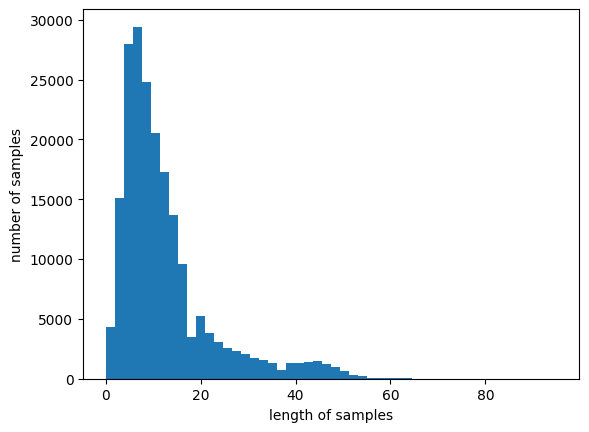

In [15]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 04. Training

In [16]:
from gensim.models import Word2Vec

In [17]:
model = Word2Vec(sentences = tokenized_data, vector_size = 50, window = 2, min_count = 5, workers = 4, sg = 1)

In [18]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (17615, 50)


In [19]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8985480070114136), ('신인', 0.896124541759491), ('유오성', 0.8759424090385437), ('김명민', 0.8669718503952026), ('스탭', 0.8668045401573181), ('이정재', 0.865781307220459), ('이상우', 0.8652229309082031), ('김수현', 0.8644756078720093), ('서영희', 0.8641738295555115), ('문소리', 0.8628478646278381)]


In [20]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.898382306098938), ('첩보', 0.8917841911315918), ('첩보물', 0.877025842666626), ('스포츠', 0.8707605004310608), ('갱스터', 0.8692891001701355), ('무협', 0.8682912588119507), ('수사물', 0.8671631217002869), ('로맨스코미디', 0.8628751039505005), ('느와르', 0.8604400157928467), ('스파이', 0.8584297299385071)]


In [21]:
model.wv["최민식"]

array([-2.6184591e-02, -1.3955101e-01,  1.1920132e-01,  1.6207674e-01,
       -2.0049809e-02, -3.6801165e-01,  2.6429436e-01,  8.1085283e-01,
        1.2559305e-02,  1.8746164e-01,  1.3727307e-01, -6.4636052e-01,
       -5.8895744e-02,  6.3837856e-02, -8.0074638e-02,  3.3891910e-01,
        1.6391852e-01, -3.2734442e-01, -7.4743360e-01, -3.5298631e-01,
        1.8958376e-01,  5.8241194e-01,  1.7604348e-01,  1.3596773e-01,
        3.8648449e-04,  1.9696867e-01,  1.8288733e-01,  1.8547891e-01,
       -3.0788735e-02,  3.3152625e-02, -4.0926734e-01, -2.3389764e-02,
       -1.7522202e-01, -5.9936953e-01,  2.2335964e-01,  5.9060156e-02,
        2.5802505e-01, -1.2716562e-01,  5.6682374e-02, -1.8905681e-01,
        3.2972255e-01, -1.9116735e-01,  1.5634796e-01,  3.3751007e-02,
        4.1777065e-01,  2.2334440e-01, -4.8420107e-01, -2.3489751e-02,
        4.5863113e-01,  1.0430259e-01], dtype=float32)

In [22]:
model.wv["김명민"]

array([-0.12127193, -0.3148507 ,  0.06683985, -0.04623494, -0.12245288,
       -0.19347039,  0.57129455,  0.43641722, -0.3085469 ,  0.0851818 ,
        0.0272545 , -0.6277921 , -0.03330846,  0.16968822, -0.00375408,
        0.2868583 ,  0.30406308, -0.25232044, -0.7675644 , -0.5135241 ,
        0.30205888,  0.47237825,  0.26595742, -0.15326758,  0.06198265,
        0.4134185 , -0.0821149 ,  0.10679672,  0.00976636,  0.01120835,
       -0.16912   , -0.09514084, -0.12304949, -0.78727084,  0.21225272,
       -0.11441687,  0.2083693 ,  0.22501302,  0.17242754, -0.10321395,
        0.3515968 , -0.01093378,  0.01365553, -0.11633876,  0.6060704 ,
        0.16089733, -0.5333307 ,  0.0307562 ,  0.4382371 , -0.07224315],
      dtype=float32)

In [23]:
model.wv.save_word2vec_format("word2vec_ko_50.model")

## 05. Loading from External word embeddings
 - 구글에서 미리 학습해둔 영어 word embedding을 다운로드받아 바로 활용해보자!

In [24]:
import gensim
import urllib.request

In [36]:
import gdown

url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

but Gdown can't. Please check connections and permissions.

In [37]:
# 위의 코드 안되면 구글의 사전 훈련된 Word2Vec 모델을 로드
url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [38]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [39]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [40]:
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04